In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mkdir ~/.kaggle/

In [ ]:
! cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [ ]:
! kaggle competitions download -c severstal-steel-defect-detection

In [ ]:
! unzip '/content/severstal-steel-defect-detection.zip' -d steel_data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [ ]:
train_df= pd.read_csv('/content/drive/MyDrive/Kaggle/steel_data/train.csv')

In [ ]:
train_df["ClassId"].value_counts()

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [ ]:
train_df.shape


(7095, 3)

In [ ]:
train_df0 = train_df[train_df['ClassId'] == 1].reset_index(drop=True)
train_df1 = train_df[train_df['ClassId'] == 2].reset_index(drop=True)
train_df2 = train_df[train_df['ClassId'] == 3].reset_index(drop=True)
train_df3 = train_df[train_df['ClassId'] == 4].reset_index(drop=True)
train_df = pd.concat([train_df0, train_df1, train_df2, train_df3], ignore_index=True)
train_df

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
2,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
3,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
4,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...
...,...,...,...
7090,fda1a539d.jpg,4,128621 3 128876 8 129131 11 129386 13 129641 1...
7091,fdb7c0397.jpg,4,155020 6 155268 16 155516 27 155764 37 156012 ...
7092,feec56162.jpg,4,99346 1 99602 1 99858 1 100113 2 100369 3 1006...
7093,ff6bfada2.jpg,4,90877 2 91131 4 91385 6 91638 9 91892 12 92146...


In [ ]:
train_images = '../content/drive/MyDrive/Kaggle/steel_data/train_images'
test_images = '../content/drive/MyDrive/Kaggle/steel_data/test_images'


In [ ]:
submission_df = pd.read_csv('../content/drive/MyDrive/Kaggle/steel_data/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(5506, 3)


,ImageId,EncodedPixels,ClassId
0,0000f269f.jpg,1 409600,0
1,000ccc2ac.jpg,1 409600,0
2,002451917.jpg,1 409600,0
3,003c5da97.jpg,1 409600,0
4,0042e163f.jpg,1 409600,0


In [ ]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

     |████████████████████████████████| 642 kB 5.6 MB/s 
     |████████████████████████████████| 840 kB 37.2 MB/s 
     |████████████████████████████████| 10.9 MB 34.9 MB/s 
     |████████████████████████████████| 3.4 MB 32.6 MB/s 
     |████████████████████████████████| 78 kB 4.1 MB/s 
     |████████████████████████████████| 1.3 MB 43.1 MB/s 
     |████████████████████████████████| 60.2 MB 26 kB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 238 kB 59.4 MB/s 
     |████████████████████████████████| 128 kB 55.9 MB/s 
     |████████████████████████████████| 25.3 MB 1.6 MB/s 
     |████████████████████████████████| 99 kB 8.1 MB/s 
     |████████████████████████████████| 352 kB 51.0 MB/s 
     |████████████████████████████████| 40 kB 4.8 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 60.2 MB 1.3 MB/s 
     |███████████████████

In [ ]:
!pip install "opencv-python-headless<4.3"

In [ ]:
val_size = 0.50
train_df['ClassId_EncodedPixels'] = train_df.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)

grouped_EncodedPixels = train_df.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)
X_train, X_test = train_test_split(grouped_EncodedPixels, test_size=val_size, random_state=42)
X_test

ImageId
0934b8bff.jpg    [(1, 76867 68 77121 172 77375 177 77630 181 77...
5994c3b58.jpg    [(1, 111018 23 111251 46 111507 46 111763 46 1...
ec52fac2d.jpg    [(3, 234878 5 235133 16 235388 22 235563 16 23...
648e67d1b.jpg    [(2, 199072 54 199222 159 199425 211 199681 21...
d245c4e7f.jpg    [(1, 70355 3 70606 9 70858 15 71109 21 71361 2...
                                       ...                        
e8226144f.jpg    [(3, 224469 43 224640 128 224812 212 225025 25...
a4334d7da.jpg    [(3, 211876 9 212124 25 212372 41 212620 58 21...
ea6227174.jpg    [(3, 19969 30 20225 88 20481 117 20737 117 209...
8bd35f020.jpg    [(3, 373729 32 373921 96 374114 159 374306 223...
28adb8aeb.jpg    [(1, 243128 4 243379 11 243630 19 243882 25 24...
Name: ClassId_EncodedPixels, Length: 3333, dtype: object

In [ ]:
l1=[]
l2=[]

for img,grouped_EncodedPixels in tqdm(X_train.items()):
  classId=grouped_EncodedPixels[0][0]
  image=cv2.imread("/content/drive/MyDrive/Kaggle/steel_data/train_images/{}".format(img),cv2.IMREAD_COLOR)
  image=cv2.resize(image,(160,25))
  l1.append(image)
  l2.append(classId)

3333it [12:37,  4.40it/s]


[[[95 95 95]
  [91 91 91]
  [86 86 86]
  ...
  [64 64 64]
  [61 61 61]
  [63 63 63]]

 [[90 90 90]
  [96 96 96]
  [80 80 80]
  ...
  [69 69 69]
  [63 63 63]
  [69 69 69]]

 [[99 99 99]
  [94 94 94]
  [87 87 87]
  ...
  [75 75 75]
  [68 68 68]
  [69 69 69]]

 ...

 [[88 88 88]
  [85 85 85]
  [86 86 86]
  ...
  [78 78 78]
  [78 78 78]
  [83 83 83]]

 [[98 98 98]
  [83 83 83]
  [79 79 79]
  ...
  [74 74 74]
  [75 75 75]
  [80 80 80]]

 [[86 86 86]
  [83 83 83]
  [90 90 90]
  ...
  [81 81 81]
  [76 76 76]
  [83 83 83]]]


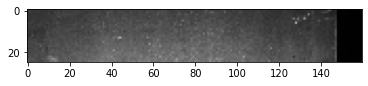

In [ ]:
print(l1[1])
i = 15
plt.imshow(l1[i])

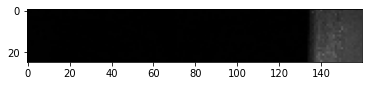

In [ ]:
i = 16
plt.imshow(l1[i])

In [ ]:
model=Sequential()

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(25,160,3)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
y_train=np.array(l1)
y_test=np.array(l2)

model.fit(y_train,y_test,batch_size=64,verbose=2,epochs=2)

Epoch 1/2
53/53 - 1s - loss: 93.0416 - accuracy: 0.3537 - 936ms/epoch - 18ms/step
Epoch 2/2
53/53 - 0s - loss: 2.2349 - accuracy: 0.6649 - 322ms/epoch - 6ms/step


In [ ]:
y_train , y_test = model.evaluate(y_train , y_test)

105/105 [==============================] - 0s 3ms/step - loss: 2.1966 - accuracy: 0.7540


In [ ]:
h1=[]
h2=[]

for img,grouped_EncodedPixels in tqdm(X_test.items()):
  classId=grouped_EncodedPixels[0][0]
  image=cv2.imread("/content/drive/MyDrive/Kaggle/steel_data/train_images/{}".format(img),cv2.IMREAD_COLOR)
  image=cv2.resize(image,(160,25))
  h1.append(image)
  h2.append(classId)

3333it [11:27,  4.85it/s]


(25, 160, 3)

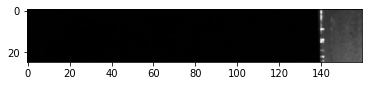

In [ ]:
i = 199
plt.imshow(h1[i])
h1[1].shape

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 10)                120010    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 120,120
Trainable params: 120,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(h1[1])

ValueError: ignored